In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

15081
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [20]:
# -----------------------------------------------------------
# --- LCHS parameters ---
# -----------------------------------------------------------
mix.reload_module(mix)

# --- rr is computed by performing simulations with and without AA ---

k_max_, nk_, rr_ = 10.0, 5, 5.856193156150e+00             # dk = 6.452e-01
# k_max_, nk_ = 10.0, 7             # dk = 1.575e-01
# k_max_, nk_ = 40.967741935484, 7  # dk = 6.452e-01
# k_max_, nk_ = 20.079, 8           # dk = 1.575e-01

Nk_ = 1 << nk_
dk_ = 2.* k_max_ / (Nk_ - 1)

arr_theta_ = np.linspace(-np.pi/2., np.pi/2., Nk_)
d_theta_ = np.diff(arr_theta_)[0]

print("nk:\t {:d}".format(nk_))
print("dk:\t {:0.12e}".format(dk_))
print("kmax\t {:0.12f}".format(k_max_))

nk:	 5
dk:	 6.451612903226e-01
kmax	 10.000000000000


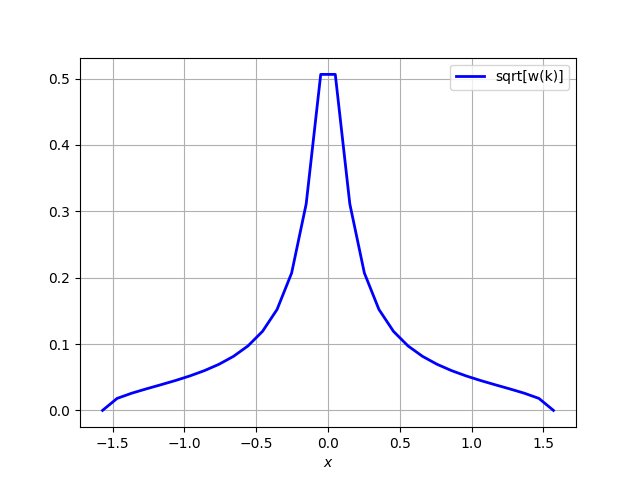

In [4]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)

def func_sqrt_weights_EFF(theta):
    w = k_max_ * np.cos(theta) / (1 + k_max_**2 * np.sin(theta)**2)
    w = w * d_theta_ / np.pi
    w = np.sqrt(w)
    return w

def plot_weights(flag_save):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        arr_theta_, func_sqrt_weights_EFF(arr_theta_), 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    plt.xlabel('$x$')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # --- Save the data ---
    if flag_save:       
        fname = "weights_sqrt_profs_k{:d}.dat".format(k_max_)
        full_name = path_save_ + "/" + fname
        mix.save_dat_plot_1d_file(full_name, arr_theta_, func_sqrt_weights_EFF(arr_theta_))
    return
# ------------------------------------------------------------
plot_weights(flag_save = False)

Reading the file ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA//N_5_OUTPUT.hdf5...
Name of the simulation is N_5
Simulation has been performed  08-31-2024 13:09:12


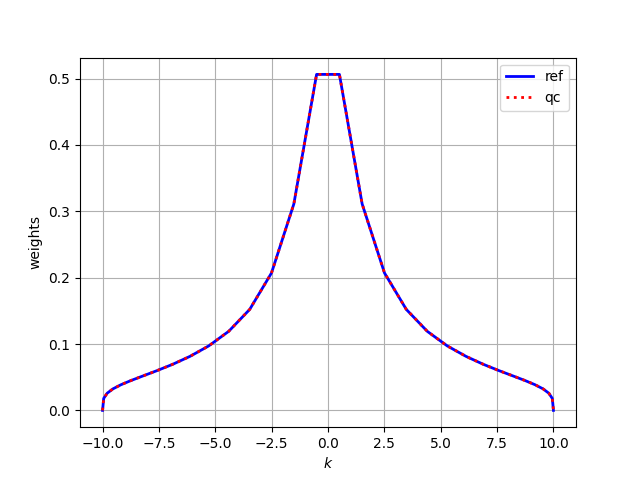


A-max (before renorm.): 5.241958492927e-01
success prob. (before renorm.): 9.992733265395e-01

N-gates: 359


In [25]:
# -----------------------------------------------------------------
# --- QuCF computation of the LCHS weights ---
# -----------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

# ----------------------------------------------------------------------
# --- QuCF computation of the LCHS weights computed by QSVT ---
# ----------------------------------------------------------------------
def QuCF_direct(flag_AA):
    k = k_max_ * np.sin(arr_theta_)
    y_ref = func_sqrt_weights_EFF(arr_theta_)

    Hadamart_norm_factor = 2**(nk_/2)

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA/"
    om.pname_ = "N_5"
    om.open()
    Ngates = om.dd_["N-gates"]

    om.set_zero_ancillae_work_states(0)
    y_qc = om.get_var_x({}, "rk")

    succ_prob = np.sum(np.abs(y_qc)**2)
    max_ampl = np.max(np.abs(y_qc))

    # --- renormalization ---
    y_qc = y_qc.real
    y_qc *= Hadamart_norm_factor
    if flag_AA:
        # y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)
        y_qc = y_qc / rr_  # here, the first order is used
            # in LCHS, rr_**2 should be used (two oracles for weight computation is used there)

    # --- Plotting results ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k, y_ref, '-b', linewidth = 2, label = "ref")
    ax.plot(k, y_qc,  ':r', linewidth = 2, label = "qc")
    plt.xlabel('$k$')
    plt.ylabel("weights")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Print some resulting parameters ---
    print()
    print("A-max (before renorm.): {:0.12e}".format(max_ampl))
    print("success prob. (before renorm.): {:0.12e}".format(succ_prob))
    print()
    print("N-gates: {:d}".format(Ngates))
    return
# ----------------------------------------------------------------------
# nk, kmax = 5, 10
# nk, kmax = 8, 100
# nk, kmax = 9, 100
# nk, kmax = 7, 40.968
# nk, kmax = 7, 10.
# nk, kmax = 8, 20.079

QuCF_direct(flag_AA = True)

In [24]:
# ----------------------------------------------------------
# --- Amplitude amplification of sqrt(weights) ---
# ----------------------------------------------------------
def print_rr(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------
# *** Here, succ_prob is a non-amplified success probability. ***
def print_NA(line_str, succ_prob):
    theta_AA = np.arcsin(np.sqrt(succ_prob))
    N_AA = int(0.5 * (np.pi/(2.*theta_AA) - 1.))  # +/- 1
    print("{:s}:\t N_AA {:d}".format(line_str, N_AA))
    return
# -----------------------------------------
def copmute_AA_QSVT():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,      nk = 5", 4.156002297806e-01, 1.682383322842e-01)
    print_rr("kmax = 40.968,  nk = 7", 4.240889334557e-01, 8.328414714733e-02)
    print_rr("kmax = 100,     nk = 8", 4.565726282533e-01, 5.760944577155e-02)
    print_rr("kmax = 10,      nk = 7", 2.132800803959e-01, 8.811472985557e-02)
    print_rr("kmax = 20.079,  nk = 8", 2.222691714695e-01, 6.168556215840e-02)

    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,      nk = 5", 1.428e-01)
    print_NA("kmax = 40.968,  nk = 7", 3.670864726304e-02)
    print_NA("kmax = 100,     nk = 8", 1.523e-02)
    print_NA("kmax = 10,      nk = 7", 1.460374767831e-01)
    print_NA("kmax = 20.079,  nk = 8", 7.424705768981e-02)
    return
# -----------------------------------------
def copmute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,  nk = 5", 5.241958492927e-01, 8.951136605564e-02)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print_NA("kmax = 10,  nk = 5", 2.913758205551e-02)
    return
# -----------------------------------------
print("REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.\n")
# copmute_AA_QSVT()
copmute_AA_Dir()

REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.

kmax = 10,  nk = 5:	 rr = 5.856193156150e+00
kmax = 10,  nk = 5:	 N_AA 4
